# Fast SLAM 1.0

2017年度確率ロボティクス課題2

In [1]:
%matplotlib inline
import numpy as np
from copy import copy, deepcopy
import math, random
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

### ランドマーク

In [2]:
class Landmark:
    # ランドマークの座標を登録
    def __init__(self, x, y):
        self.pos = np.array([[x],[y]])
        
    #描画
    def draw(self):
        xs, ys = self.pos
        plt.scatter(xs, ys, s=300, marker="*", label="landmarks", color="orange")
        
    #ランドマークの位置(x, y)と相対距離と相対角度を返す関数
    def relative_pos(self, pose):
        x, y, theta = pose
        lx, ly = self.pos[0][0], self.pos[1][0]
        distance = math.sqrt((x-lx)**2 + (y-ly)**2)
        direction = math.atan2(ly-y, lx-x) - theta
        
        return (distance, direction, lx, ly)

### 地図

In [3]:
class Map:
    #ランドマークを格納するリスト
    def __init__(self):
        self.landmarks = []
    
    #地図にランドマークを追加
    def append_landmark(self, x, y):
        self.landmarks.append(Landmark(x, y))
        
    #描画
    def draw(self):
        for l in self.landmarks:
            l.draw()
            
    #ランドマークの位置（x, y）と相対距離と相対角度とID(番号)のリストを返す
    def relative_landmark_positions(self, pose):
        positions = [[*ln.relative_pos(pose), i] for i, ln in enumerate(self.landmarks)]
        
        return positions

### 地図にランドマークを登録して表示するテスト

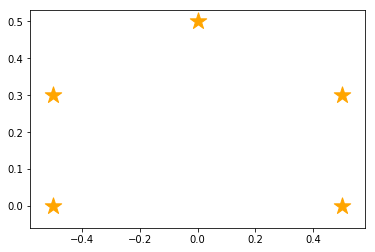

In [4]:
m = Map()
m.append_landmark(-0.5, 0.0)
m.append_landmark(0.5, 0.0)
m.append_landmark(0.0, 0.5)
m.append_landmark(0.5, 0.3)
m.append_landmark(-0.5, 0.3)
m.draw()

### ロボットです

In [5]:
class Robot:
    # 初期位置を設定
    def __init__(self, pose):
        self.pose = pose
        
    # 描画
    def draw(self):
        x, y, theta = self.pose
        plt.quiver([x], [y], [math.cos(theta)], [math.sin(theta)], color="red", label="actual robot motion")
        
    # ランドマーク観測
    def observation(self, m):
        measurements = m.relative_landmark_positions(self.pose)
        observations = []
        
        for m in measurements:
            distance, direction, lx, ly, i = m
            # 後ろ側は観測できないようにする
            if(math.cos(direction) < 0.0):
                continue
                
            # 相対距離に10%の標準偏差の雑音を入れる
            measured_distance = random.gauss(distance, distance*0.1)
            # 相対角度に5度の標準偏差の雑音を入れる
            measured_direction = random.gauss(direction, math.radians(5.0))
            
            observations.append([measured_distance, measured_direction, lx, ly, i])
            
        return observations
    
    # 移動モデル
    def motion_model(self, pos, fw, rot):
        # fwの10%の標準偏差の雑音を入れる
        actual_fw = random.gauss(fw, fw/10.0)
        # 3度の標準偏差の雑音を入れる
        dir_error = random.gauss(0.0, math.radians(3.0))
        
        px, py, pt = pos
        
        # 前進
        x = px + actual_fw * math.cos(pt + dir_error)
        y = py + actual_fw * math.sin(pt + dir_error)
        
        # 回転にrotの10%の標準偏差の雑音を入れる
        t = pt + dir_error + random.gauss(rot, rot/10.0)
        
        return np.array([x, y, t])

### ロボットを地図に置いてみるテスト

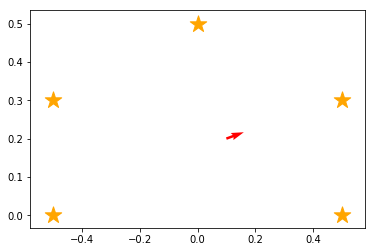

In [6]:
robot = Robot(np.array([0.1, 0.2, math.radians(20.0)]))
robot.draw()
m.draw()

### ロボットとランドマークの位置関係の描画

[[0.4915798419535959, -0.6798892853201307, 0.5, 0.0, 1], [0.311710661989288, 1.4883293154371955, 0.0, 0.5, 2], [0.40110511006951494, 0.001889676034287871, 0.5, 0.3, 3]]


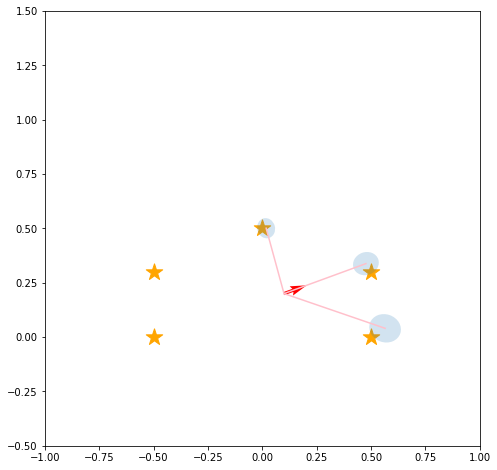

In [7]:
observations = robot.observation(m)
print(observations)

fig = plt.figure(0, figsize=(8, 8))
sp = fig.add_subplot(111, aspect="equal")
sp.set_xlim(-1.0, 1.0)
sp.set_ylim(-0.5, 1.5)

for observation in observations:
    x, y, theta = robot.pose
    distance, direction, lx, ly, i = observation
    lx = distance * math.cos(theta+direction) + x
    ly = distance * math.sin(theta+direction) + y
    # ロボットの観測したランドマークとロボットをピンク色の線で表示
    plt.plot([robot.pose[0], lx], [robot.pose[1], ly], color="pink")
    
    c = math.cos(theta + direction)
    s = math.sin(theta + direction)
    rot = np.array([[c, -s], [s, c]])
    
    err_robot = np.diag([(distance*0.1)**2.0, (distance*math.sin(math.radians(5.0)))**2])
    err_world = rot@err_robot@rot.T
    
    eig_vals, eig_vec = np.linalg.eig(err_world)
    v1 = eig_vals[0] * eig_vec[:, 0]
    v2 = eig_vals[1] * eig_vec[:, 1]
    v1_direction = math.atan2(v1[1], v1[0])
    
    # 誤差楕円の表示
    elli = Ellipse([lx, ly], width=3*math.sqrt(np.linalg.norm(v1)), height=3*math.sqrt(np.linalg.norm(v2)), angle=math.degrees(v1_direction))
    elli.set_alpha(0.2)
    sp.add_artist(elli)
    
robot.draw()
m.draw()

## FastSLAMの実装

### ランドマークの推定結果の入れ物
* ランドマークの位置 $\hat{\boldsymbol{m}_i}$ self.pos
* ランドマークの共分散 $\Sigma_i$ self.cov

In [8]:
class LandmarkEstimation:
    def __init__(self):
        self.pos = np.zeros((2,1))
        self.cov = np.diag((1.0e5**2, 1.0e5**2))

### パーティクルのクラス

* パーティクルの持つ変数
  * 重み
  * ロボットの姿勢
  * 地図
  
* メソッド
  * ロボットの動作をパーティクルに反映
    * MCLと同じ
  * 計測値をパーティクルに反映
    * 重みの計算
      * MCLと同じ
    * 地図の更新
      * 情報行列にして足し合わせて逆行列にして戻す
        * $\Sigma_i \longleftarrow (\Sigma_i^{-1} + Q_z^{-1})^{-1}$
      * カルマンゲインの計算
        * $K \longleftarrow \Sigma_i Q_z^{-1}$
      * カルマンゲインから位置を更新
        * $\hat{m_i} \longleftarrow (1-K)\hat{m_i} + K\boldsymbol{z}$

In [9]:
class Particle:
    def __init__(self, pose, w):
        self.w = w
        self.pose = pose        
        # ランドマークは5つ
        self.map = [LandmarkEstimation() for i in range(5)]
    
    # 動作モデルの反映
    def motion_update(self, fw, rot, robot):
        self.pose = robot.motion_model(self.pose, fw, rot)
        
    # 計測値の反映
    def measurement_update(self, measurement):
        x, y, theta = self.pose
        distance, direction, lx, ly, i = measurement
        ln = self.map[i]
        lx = distance * math.cos(theta + direction) + x
        ly = distance * math.sin(theta + direction) + y
        # FastSLAMのパーティクルの重みの更新
        delta = np.array([[x-lx], [y-ly]])
        coef = 2 * math.pi * math.sqrt(np.linalg.det(ln.cov))
        inexp = -0.5 * (delta.T@np.linalg.inv(ln.cov)@delta)
        self.w *= 1.0/coef * math.exp(inexp)
        
        # 地図の更新
        z = np.array([[lx], [ly]])
        
        c = math.cos(theta + direction)
        s = math.sin(theta + direction)
        rot = np.array([[c, -s], [s, c]])
        
        err_robot = np.diag([(distance*0.1)**2, (distance*math.sin(math.radians(5.0)))**2])
        err_world = rot@err_robot@rot.T
        ln.cov = np.linalg.inv(np.linalg.inv(ln.cov)+np.linalg.inv(err_world))
        K = (ln.cov).dot(np.linalg.inv(err_world))
        ln.pos += K.dot(z - ln.pos)
        
    # 描画
    def draw(self,i):
        fig = plt.figure(i,figsize=(4, 4))
        sp = fig.add_subplot(111, aspect='equal')
        sp.set_xlim(-1.0,1.0)
        sp.set_ylim(-0.5,1.5)
        
        m.draw()
        x,y,theta = self.pose
        plt.quiver([x],[y],[math.cos(theta)],[math.sin(theta)],color="red",label="actual robot motion")
        
        for e in self.map:
            eig_vals,eig_vec = np.linalg.eig(e.cov)
            v1 = eig_vals[0] * eig_vec[:,0]
            v2 = eig_vals[1] * eig_vec[:,1]
            v1_direction = math.atan2(v1[1],v1[0])
    

            x,y = e.pos
            elli = Ellipse([x,y],width=3*math.sqrt(np.linalg.norm(v1)),height=3*math.sqrt(np.linalg.norm(v2)),angle=v1_direction/3.14*180)
            elli.set_alpha(0.5)
        
            sp.add_artist(elli)

### FastSLAMのクラス
* 変数
  * パーティクル群
* メソッド
  * ロボットの動作をパーティクルに反映
    * MCLと同じ
  * 計測値をパーティクルに反映
    * $P(\boldsymbol{m},\boldsymbol{x}|\boldsymbol{z}) = \eta P(\boldsymbol{z}|\boldsymbol{m},\boldsymbol{x})P(\boldsymbol{m},\boldsymbol{x})$（ベイズの定理）
      * この式が上の各パーティクルの処理に分解できる（Rao-Blackwellization）
  * リサンプリング
    * MCLと同じ

In [10]:
class FastSLAM:
    # パーティクルの数を設定
    def __init__(self, pose):
        # パーティクル数300
        p_num = 300
        self.particles = [Particle(pose, 1.0/p_num) for i in range(p_num)]
    
    # 描画
    def draw(self):
        for (i, p) in enumerate(self.particles):
            p.draw(i)
            # 3個だけパーティクルを描画する
            if i > 3:
                return
    
    # 動作モデルの反映
    def motion_update(self, fw, rot, robot):
        for p in self.particles:
            p.motion_update(fw, rot, robot)
            
    # 計測値の反映
    def measurement_update(self, measurement):
        for p in self.particles:
            p.measurement_update(measurement)
            
        self.resampling()
        
    # リサンプリング
    def resampling(self):
        num = len(self.particles)
        ws = [e.w for e in self.particles]
        
        if sum(ws) < 1e-100:
            ws = [e + 1e-100 for e in ws]
            
        ps = random.choices(self.particles, weights=ws, k=num)
        
        self.particles = [deepcopy(e) for e in ps]

## SLAMの実行

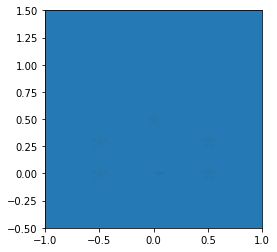

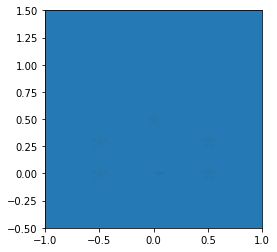

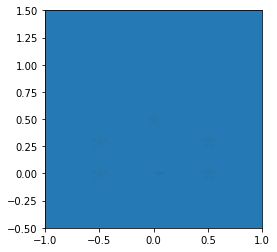

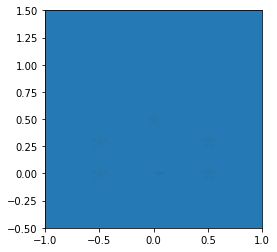

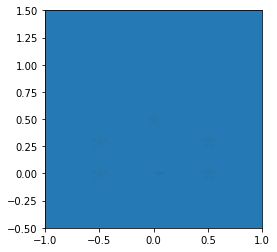

In [11]:
m = Map()
m.append_landmark(-0.5, 0.0)
m.append_landmark(0.5, 0.0)
m.append_landmark(0.0, 0.5)
m.append_landmark(0.5, 0.3)
m.append_landmark(-0.5, 0.3)
robot.pose = np.array([0.0, 0.0, 0.0])
slam = FastSLAM(robot.pose)
slam.draw()

### 30ステップ後のパーティクル

Map after 30 steps


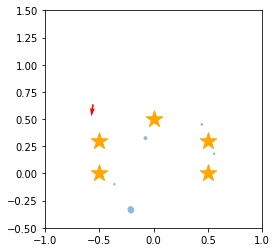

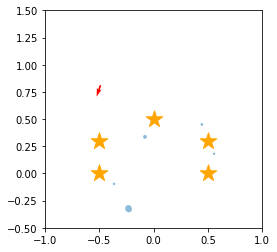

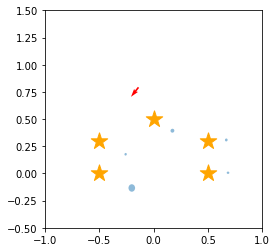

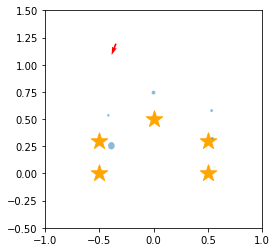

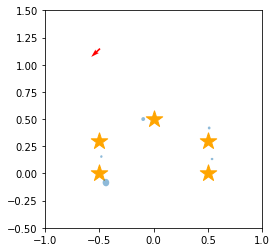

In [12]:
def one_step(m):
    slam.motion_update(0.2, math.radians(20.0), robot)
    robot.pose = robot.motion_model(robot.pose, 0.2, math.radians(20.0))
    measurements = robot.observation(m)
    for m in measurements:
        slam.measurement_update(m)
        
n = 30
for i in range(n):
    one_step(m)
    
print("Map after {} steps".format(n))
slam.draw()